In [3]:
# -*- coding:utf-8-*-
# import transformers
# import tensorflow
# import keras
# import torch
# import sklearn
# print(sklearn.__version__)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# print('transformers版本：', transformers.__version__)
# print('tensorflow版本：', tensorflow.__version__)
# print('keras版本：', keras.__version__)
# print('torch版本：', torch.__version__)

# data = np.random.randint(10, 100, (4, 4))
# print(data)
#
# scl = StandardScaler()
# data = scl.fit_transform(data)
# print(data)
# print(StandardScaler.__name__)

from TabNet_Model_Train_Supervise import super
from Tabnet_pre_train import sesuper

a, b = super()
c, d = sesuper()

print(d)
print(b)
print(a)
print(c)



[752.2611130395613, 654.8039989498801, 512.5202260612587, 327.4324161305147, 156.50984108704577, 77.3222076766289, 61.27800467229813, 42.86882135071063, 34.29054006852926, 29.60759103520529, 27.304132513541575, 27.61671849473819, 23.29505561106174, 22.67190540811766, 20.140780685621834, 19.200772013178515, 19.78142633533888, 18.6112174522586, 17.21858239139683, 16.99154962460314, 17.69855313732087, 19.744914652798403, 17.333063752271524, 17.69778711929212, 18.50250825923006, 17.291588584867064, 15.214349215820837, 16.150902076294294, 16.853805011108925, 14.482886716659305, 14.569667601345943, 15.275028376531395, 13.879406586952154, 15.242047858546078, 13.682417229224141, 14.472537843876625, 15.370826061692094, 15.644931281485208, 15.393773464766602, 15.225929572216236, 14.132138170162952, 14.807147218986085, 14.864319764387659, 13.847330428606469, 13.614316643396101, 13.964773655621872, 11.823207515897163, 13.645928709886679, 13.890376777867846, 11.904910320188941, 12.650873022749913, 

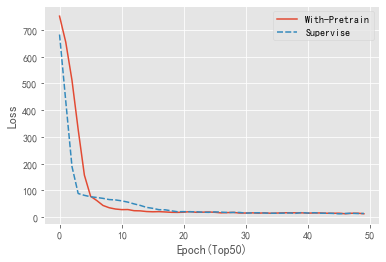

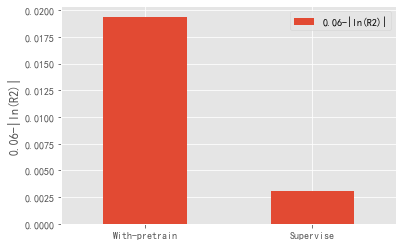

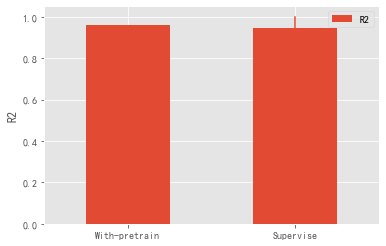

In [10]:


plot_data = pd.DataFrame(data={
    # "x": x,
    "With-Pretrain": d[:50],
    "Supervise": b[:50]
})

plt.style.use('ggplot')
plt.figure()
sns.lineplot(data=plot_data)
plt.legend()
plt.xlabel('Epoch(Top50)')
plt.ylabel('Loss')
plt.savefig('picture/pre-train-and-supervise-loss.png')
plt.show()


name = ['With-pretrain', 'Supervise']
value = 0.06-np.abs(np.log([c, a]))
value2=[c, a]

plot_data = pd.DataFrame(data={
    '': name,
    '0.06-|ln(R2)|': value
})
plot_data = plot_data.set_index(keys='', drop=True)
plot_data.plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('0.06-|ln(R2)|')
plt.savefig('picture/pre-train-and-supervise-r2.png')
plt.show()

plot_data = pd.DataFrame(data={
    '': name,
    'R2': value2
})
plot_data = plot_data.set_index(keys='', drop=True)
plot_data.plot(kind='bar')
plt.plot([1,1],[0,1])
plt.xticks(rotation=0)
plt.ylabel('R2')
# plt.savefig('picture/pre-train-and-supervise-r2.png')
plt.show()

In [1]:
# -*- coding:utf-8-*-
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from def_fun import plot_history_loss, plot_history_mae_mse
import shap

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(10)

data = pd.read_excel('data/bistandard+soft_fill.xlsx')
data_x = data.iloc[:, :-1]
feat_importance = data_x.columns
data_y = data.iloc[:, -1]  # ！！！

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, shuffle=True, random_state=10)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.5, shuffle=True, random_state=10)

train_x = np.array(train_x)
valid_x = np.array(valid_x)
test_x = np.array(test_x)
train_y = np.array(train_y).reshape(-1, 1)
test_y = np.array(test_y).reshape(-1, 1)
valid_y = np.array(valid_y).reshape(-1, 1)

print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

# tabnet_params = {"cat_idxs":cat_idxs,
#                  "cat_dims":cat_dims,
#                  "cat_emb_dim":1,
#                  "optimizer_fn":torch.optim.Adam,
#                  "optimizer_params":dict(lr=2e-2),
#                  "scheduler_params":{"step_size":50, # how to use learning rate scheduler
#                                  "gamma":0.9},
#                  "scheduler_fn":torch.optim.lr_scheduler.StepLR,
#                  "mask_type":'entmax' # "sparsemax"
#                 }

clf = TabNetRegressor(
    verbose=False,
    seed=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    n_a=8,
    n_d=8,
    n_steps=3,
    scheduler_params={"step_size": 10,  # how to use learning rate scheduler
                      "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    # mask_type='entmax'  # "sparsemax"
)
clf.fit(
    train_x, train_y,
    batch_size=256,
    max_epochs=200,
    eval_set=[(valid_x, valid_y)],
    eval_metric=['rmse', 'mae'],
    patience=0
)

pred_y = clf.predict(test_x)
pred_y = pred_y.reshape(1, -1)[0]
test_y = test_y.reshape(1, -1)[0]

mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
importance = clf.feature_importances_
print(clf.network)

# 局部重要性
explain_matrix, masks = clf.explain(test_x)
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

for i in range(3):  # 代表展示前3个MASK
    axs[i].imshow(masks[i][:50])  # 50 代表前50个样本
    axs[i].set_title(f"mask {i}")

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

plot_history_loss(clf.history, 'supervise')
plot_history_mae_mse(clf.history, 'supervise')

plot_data = pd.DataFrame(data={
    # "x": x,
    "true": test_y,
    "pred": pred_y
})

plt.style.use('ggplot')
plt.figure()
sns.lineplot(data=plot_data)
plt.legend()
plt.savefig('picture/supervise-true_pred.png')
plt.show()






KeyboardInterrupt: 

Index(['描述', '价格', '房源类型', '出租类型', '可住人数', '面积', '省份', '城区', '房源评论数', '房客评价',
       '房源综合得分', '房主好评率', '房主回复率', '房主接单率', '其他房源数', '其他房源平均分', '房源好评率'],
      dtype='object')
[0.01144191 0.02894583 0.03034033 0.11811631 0.02057143 0.02259481
 0.01457156 0.00114405 0.11511375 0.06700652 0.02630201 0.29029455
 0.09600175 0.09454356 0.00131477 0.00578304 0.0559138 ]


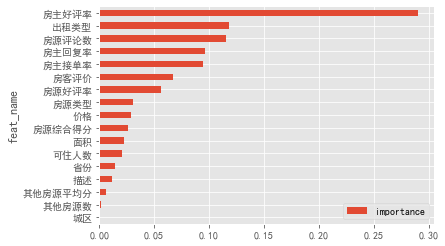

In [11]:
print(feat_importance)
print(importance)






zip_importance_feat = zip(feat_importance, importance)
dict_importance_feat = dict(zip_importance_feat)

dict_importance_feat = dict(sorted(dict_importance_feat.items(), key=lambda x: x[1]))
feat_importance= dict_importance_feat.keys()
importance=dict_importance_feat.values()

plot_data = pd.DataFrame(data={
    'feat_name': feat_importance,
    'importance': importance
})
plot_data = plot_data.set_index(keys='feat_name', drop=True)
plot_data.plot(kind='barh')
plt.legend(loc="lower right")
plt.savefig('picture/supervise-importance.png')
plt.show()


mean_fangyuantezheng